In [ ]:
!sudo apt-get install swig
!pip install gymnasium[box2d]
!pip install moviepy
!pip install numpy
!pip install torch
!pip install tqdm

In [1]:
import logging
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('moviepy').setLevel(logging.WARNING)
logging.getLogger('Moviepy').setLevel(logging.WARNING)


import gymnasium as gym
from gym.wrappers.record_video import RecordVideo

import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import glob
import moviepy.editor as mpy
from IPython.display import Video

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining the DQN network
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# Definition of Replay Memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Epsilon-greedy strategy for action selection
def select_action(state):
    global steps_done  # Global steps for decreasing epsilon
    # Random value to determine whether to take a greedy or random step
    sample = random.random()
    
    # Setting the decision threshold - epsilon level
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    
    # Incrementing the step count
    steps_done += 1
    
    # If the random threshold is greater than the epsilon threshold
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) returns the maximum value of each row's column.
            # The second column in the max result is the index of the location
            # where the maximum element was found,
            # so we select the action with the highest expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Otherwise, choose a random action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def optimize_model(batch_size: int):
    if len(memory) < batch_size:
        return
    
    # Retrieve a batch from memory
    transitions = memory.sample(batch_size)
    # Convert it to a namedtuple
    batch = Transition(*zip(*transitions))

    # Calculate the mask for non-final states and concatenate batch elements
    # (A final state should be the one after which the simulation ended)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    # Collect batches for states, actions, and rewards
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), 
    # then we select the columns of undertaken actions.
    # These are the actions that would have been taken for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected action values for non-final next states are calculated
    # based on the "older" target network; selecting their best reward with max(1)[0].
    # This is combined by the mask, so we'll have either the expected state value
    # or 0, if the state was final.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Combine everything into a total loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Prepare the gradient
    optimizer.zero_grad()
    loss.backward()
    # Clip gradient values - addressing the vanishing/exploding gradient problem
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    
    optimizer.step()


# Training parameters
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
LR = 1e-4
FULL_MEMORY_LENGTH = 10000
TAU = 0.005

# Initializing "LunarLander-v2" environment with video recording

# Creating directory for videos
video_path = 'training_videos'
os.makedirs(video_path, exist_ok=True)

env = gym.make("LunarLander-v2", render_mode="rgb_array")
env = RecordVideo(env, video_path, episode_trigger=lambda episode_id: episode_id % 50 == 0)

# Getting the number of actions and observations from the environment
n_actions = env.action_space.n
# Get the number of degrees of freedom in states
state, info = env.reset()
n_observations = len(state)

# Initializing networks and optimizer
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(FULL_MEMORY_LENGTH)

steps_done = 0
episode_durations = []
total_rewards = []

# Collecting data for visualization
episode_rewards = []
mean_rewards = []
mean_100ep_rewards = []

# Model training
if torch.cuda.is_available():
    num_episodes = 1500
else:
    num_episodes = 500

for i_episode in tqdm(range(num_episodes)):
    episode_reward = 0
    # Initialize the initial state for each episode
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        
        reward = torch.tensor([reward], device=device)
        # Combine done for the two terminal states
        done = terminated or truncated
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model(BATCH_SIZE)

        # Soft update of weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if done:
            # Add to the array the duration of the episode
            episode_durations.append(t + 1)        
            break

    episode_rewards.append(episode_reward)
    mean_rewards.append(np.mean(episode_rewards))
    if len(episode_rewards) >= 100:
        mean_100ep_rewards.append(np.mean(episode_rewards[-100:]))
    else:
        mean_100ep_rewards.append(np.mean(episode_rewards))

# Closing the environment
env.close()

# Creating the final video
video_files = glob.glob(f"{video_path}/*.mp4")
video_clips = [mpy.VideoFileClip(vf) for vf in video_files]
final_clip = mpy.concatenate_videoclips(video_clips)
final_video_path = "final_training_video1.mp4"
# Here you can specify the fps that was used during video recording
fps = 30  # or 60, depending on the environment
final_clip.write_videofile(final_video_path, fps=fps)


  0%|                                                                                                           | 0/500 [00:00<?, ?it/s]

Moviepy - Building video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-0.mp4.
Moviepy - Writing video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-0.mp4




  0%|▏                                                                                                  | 1/500 [00:00<03:36,  2.31it/s]

Moviepy - Done !
Moviepy - video ready /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-0.mp4


 10%|█████████▊                                                                                        | 50/500 [01:19<07:17,  1.03it/s]

Moviepy - Building video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-50.mp4.
Moviepy - Writing video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-50.mp4




 10%|█████████▉                                                                                        | 51/500 [01:20<06:43,  1.11it/s]

Moviepy - Done !
Moviepy - video ready /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-50.mp4


 20%|███████████████████▍                                                                             | 100/500 [03:52<24:44,  3.71s/it]

Moviepy - Building video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-100.mp4.
Moviepy - Writing video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-100.mp4




 20%|███████████████████▌                                                                             | 101/500 [03:54<30:09,  4.53s/it]

Moviepy - Done !
Moviepy - video ready /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-100.mp4


 30%|█████████████████████████████                                                                    | 150/500 [06:32<09:13,  1.58s/it]

Moviepy - Building video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-150.mp4.
Moviepy - Writing video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-150.mp4




 30%|█████████████████████████████▎                                                                   | 151/500 [06:33<14:59,  2.58s/it]

Moviepy - Done !
Moviepy - video ready /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-150.mp4


 40%|██████████████████████████████████████▊                                                          | 200/500 [07:50<05:40,  1.13s/it]

Moviepy - Building video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-200.mp4.
Moviepy - Writing video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-200.mp4




 40%|██████████████████████████████████████▉                                                          | 201/500 [07:51<08:09,  1.64s/it]

Moviepy - Done !
Moviepy - video ready /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-200.mp4


 50%|████████████████████████████████████████████████▌                                                | 250/500 [08:58<06:23,  1.53s/it]

Moviepy - Building video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-250.mp4.
Moviepy - Writing video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-250.mp4




 50%|████████████████████████████████████████████████▋                                                | 251/500 [08:59<08:19,  2.00s/it]

Moviepy - Done !
Moviepy - video ready /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-250.mp4


 60%|██████████████████████████████████████████████████████████▏                                      | 300/500 [10:32<06:16,  1.88s/it]

Moviepy - Building video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-300.mp4.
Moviepy - Writing video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-300.mp4




 60%|██████████████████████████████████████████████████████████▍                                      | 301/500 [10:32<06:15,  1.89s/it]

Moviepy - Done !
Moviepy - video ready /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-300.mp4


 70%|███████████████████████████████████████████████████████████████████▉                             | 350/500 [12:26<04:02,  1.62s/it]

Moviepy - Building video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-350.mp4.
Moviepy - Writing video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-350.mp4




 70%|████████████████████████████████████████████████████████████████████                             | 351/500 [12:27<05:30,  2.22s/it]

Moviepy - Done !
Moviepy - video ready /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-350.mp4


 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 400/500 [13:39<01:23,  1.20it/s]

Moviepy - Building video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-400.mp4.
Moviepy - Writing video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-400.mp4




 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 401/500 [13:39<01:36,  1.02it/s]

Moviepy - Done !
Moviepy - video ready /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-400.mp4


 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 450/500 [14:34<00:36,  1.39it/s]

Moviepy - Building video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-450.mp4.
Moviepy - Writing video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-450.mp4




 90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 451/500 [14:34<00:47,  1.03it/s]

Moviepy - Done !
Moviepy - video ready /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-450.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [16:03<00:00,  1.93s/it]


Moviepy - Building video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-500.mp4.
Moviepy - Writing video /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-500.mp4



Moviepy - Done !
Moviepy - video ready /home/iagaraev/Desktop/courses/OTUS/RL/DeepLearning/training_videos/rl-video-episode-500.mp4
Moviepy - Building video final_training_video1.mp4.
Moviepy - Writing video final_training_video1.mp4



Moviepy - Done !
Moviepy - video ready final_training_video1.mp4


In [2]:
import base64
from IPython.display import HTML

# Encode the video in Base64
# This reads the video file, encodes it into Base64, which is a way of representing binary data in ASCII string format.
# It's useful for embedding binary data (like a video) directly in the notebook.
with open(final_video_path, 'rb') as video_file:
    video_base64 = base64.b64encode(video_file.read()).decode()

# Embedding the video in HTML
# Here, we create an HTML string that includes a <video> tag.
# The source of the video is set to the Base64 encoded string of the video file.
# This allows the video to be embedded and played directly in the notebook.
html = '''
<video width="600" height="600" controls>
  <source src="data:video/mp4;base64,{0}" type="video/mp4">
</video>
'''.format(video_base64)

# Display the video in Jupyter Notebook
# This line renders the above HTML within the notebook.
# As a result, the video player will appear in the notebook, allowing you to play the embedded video.
HTML(html)



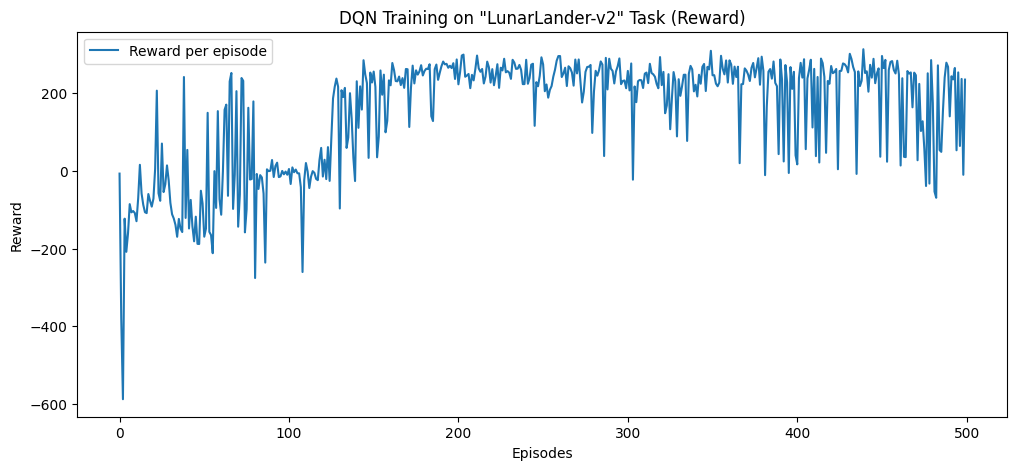

In [3]:
# Visualization of results
plt.figure(figsize=(12, 5))
plt.plot(episode_rewards, label='Reward per episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('DQN Training on "LunarLander-v2" Task (Reward)')
plt.legend()
plt.show()


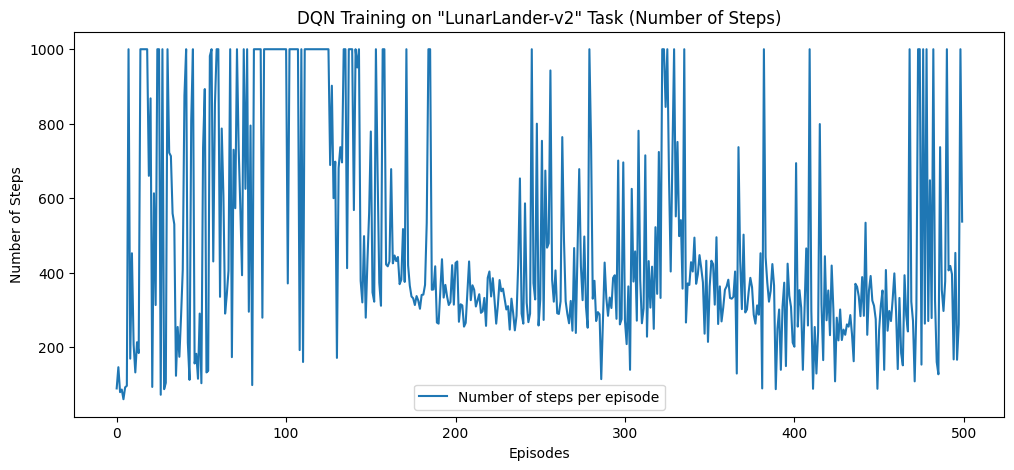

In [4]:
# Visualization of results
plt.figure(figsize=(12, 5))
plt.plot(episode_durations, label='Number of steps per episode')
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('DQN Training on "LunarLander-v2" Task (Number of Steps)')
plt.legend()
plt.show()

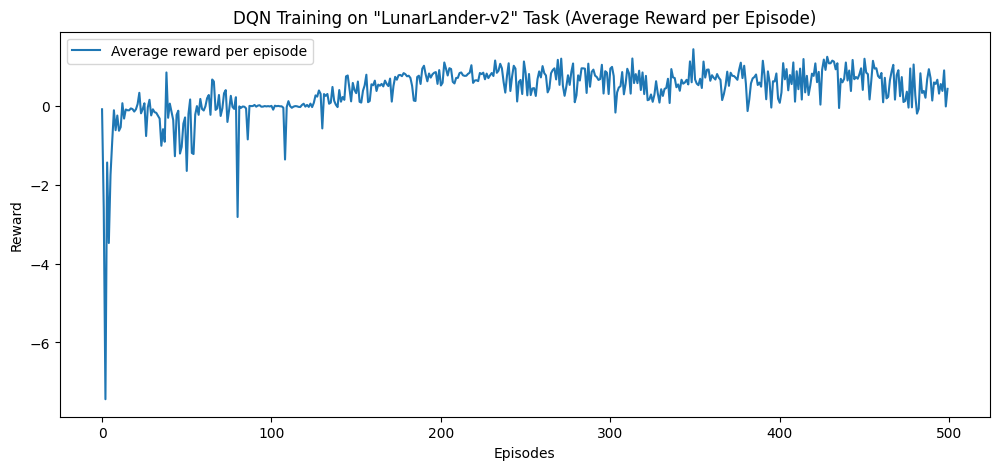

In [5]:
# Visualization of results
plt.figure(figsize=(12, 5))
average_reward_in_episode = [i/j for i, j in zip(episode_rewards, episode_durations)]
plt.plot(average_reward_in_episode, label='Average reward per episode')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('DQN Training on "LunarLander-v2" Task (Average Reward per Episode)')
plt.legend()
plt.show()


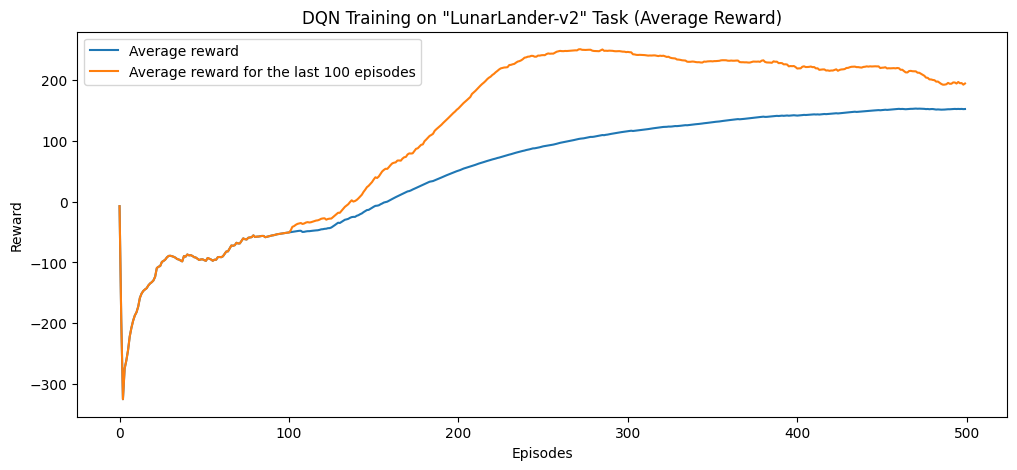

In [6]:
# Visualization of results
plt.figure(figsize=(12, 5))
plt.plot(mean_rewards, label='Average reward')
plt.plot(mean_100ep_rewards, label='Average reward for the last 100 episodes')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('DQN Training on "LunarLander-v2" Task (Average Reward)')
plt.legend()
plt.show()
